# MNIST/Fashion MNIST GAN Implementation

This notebook implements a Generative Adversarial Network (GAN) trained on either the MNIST digits or Fashion MNIST dataset using PyTorch. This serves as the foundation for investigating whether informative data samples exist for GAN training, similar to those found in supervised learning.

## Thesis Context
Recent research has shown that state-of-the-art machine learning models can be trained effectively using only specific subsets of training data. These "informative samples" enhance generalization in neural networks. While this phenomenon has been observed in supervised learning, this project aims to investigate whether similar informative samples exist when training generative models like GANs.

## Notebook Overview
1. **Setup and Imports**: Libraries and device configuration
2. **Hyperparameters**: Configuration for the GAN training
3. **Model Architecture**: Implementation of Generator and Discriminator networks
4. **Data Loading**: Dataset preparation with choice between MNIST digits or Fashion MNIST
5. **Visualization Functions**: Utilities for tracking GAN performance
6. **Training Loop**: Implementation of the GAN training process
7. **Execution and Results**: Running the training and analyzing outputs

## 1. Setup and Imports

First, we'll import the necessary libraries and set up the computational device (CPU or GPU).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import os
import time
import random

# Set random seed for reproducibility
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Hyperparameters

Here we define all the hyperparameters that control the GAN training process. These include:

- Batch size: Number of images processed in each training step
- Latent dimension: Size of the random noise vector input to the generator
- Hidden dimensions: Size of hidden layers in the networks
- Learning rates and optimizer parameters
- Training duration and image sampling frequency

In [2]:
# Hyperparameters
batch_size = 128
latent_dim = 128     # Size of generator input noise vector
hidden_dim = 256     # Size of hidden layers
image_size = 28 * 28 # MNIST image dimensions flattened
lr = 0.0002     
beta1 = 0.5          
beta2 = 0.999  
num_epochs = 100 
sample_interval = 10 # Save images every 10 epochs

## 3. Model Architecture

### Generator Network

The Generator transforms random noise vectors into synthetic images. Its architecture consists of:
- Input: Random noise vector (latent_dim)
- Multiple fully connected layers with LeakyReLU activations
- Output: Image with values in range [-1, 1] through Tanh activation

This implementation uses a simple MLP (Multi-Layer Perceptron) architecture rather than convolutional layers for simplicity.

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 4, output_dim),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)  # Reshape to image dimensions
        return img

### Discriminator Network

The Discriminator evaluates whether an image is real (from the dataset) or fake (generated). Its architecture consists of:
- Input: Flattened image (28×28 = 784 dimensions)
- Multiple fully connected layers with LeakyReLU activations and dropout for regularization
- Output: Single value between 0-1 through Sigmoid activation (probability of image being real)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 4, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()  # Output between 0-1 (probability of being real)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)  # Flatten the image
        validity = self.model(img_flat)
        return validity

### Initialize Models and Optimizers

Here we:
1. Initialize both networks
2. Define the loss function (Binary Cross Entropy)
3. Set up optimizers for both networks

In [5]:
# Initialize models
generator = Generator(latent_dim, hidden_dim, image_size).to(device)
discriminator = Discriminator(image_size, hidden_dim).to(device)

# Loss function
adversarial_loss = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

## 4. Data Loading

Here we set up either the MNIST digits or Fashion MNIST dataset with appropriate transformations:
- ToTensor: Converts PIL images to PyTorch tensors
- Normalize: Scales pixel values from [0,1] to [-1,1] to match the Generator's Tanh output

We've extended the function to support both dataset types.

In [7]:
def load_data(subset_percentage=100, dataset_type='digits'):
    """
    Load either MNIST digits or Fashion MNIST dataset
    
    Parameters:
    - subset_percentage: Percentage of the full dataset to use (integer from 1-100)
    - dataset_type: Either 'digits' for original MNIST or 'fashion' for Fashion MNIST
    
    Returns:
    - DataLoader and Dataset objects
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
    ])
    
    if dataset_type.lower() == 'digits':
        full_dataset = torchvision.datasets.MNIST(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )
        class_names = [str(i) for i in range(10)]  # 0-9 digits
    elif dataset_type.lower() == 'fashion':
        full_dataset = torchvision.datasets.FashionMNIST(
            root='./data',
            train=True,
            download=True,
            transform=transform
        )
        class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                       'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    else:
        raise ValueError("dataset_type must be either 'digits' or 'fashion'")
    
    all_targets = full_dataset.targets.numpy()
    
    # Count instances of each class
    class_counts = [0] * 10
    for label in all_targets:
        class_counts[label] += 1
    
    print(f"Full {dataset_type} dataset distribution:")
    for class_idx, count in enumerate(class_counts):
        class_label = class_names[class_idx] if dataset_type.lower() == 'fashion' else f"Digit {class_idx}"
        print(f"{class_label}: {count} samples")
    
    if subset_percentage == 100:
        selected_dataset = full_dataset
    else:
        class_indices = [[] for _ in range(10)]
        
        for idx, label in enumerate(all_targets):
            class_indices[label].append(idx)
        
        total_subset_size = int(len(full_dataset) * subset_percentage / 100)
        samples_per_class = total_subset_size // 10
        
        stratified_indices = []
        for class_idx in range(10):
            class_idx_list = class_indices[class_idx]
            random_idx = torch.randperm(len(class_idx_list))

            selected_idx = [class_idx_list[i] for i in random_idx[:samples_per_class]]
            stratified_indices.extend(selected_idx)
            
        random.shuffle(stratified_indices)
        selected_dataset = torch.utils.data.Subset(full_dataset, stratified_indices)
        
        subset_class_counts = [0] * 10
        for idx in stratified_indices:
            label = all_targets[idx]
            subset_class_counts[label] += 1
        
        print(f"\nStratified subset distribution ({dataset_type}):")
        for class_idx, count in enumerate(subset_class_counts):
            class_label = class_names[class_idx] if dataset_type.lower() == 'fashion' else f"Digit {class_idx}"
            print(f"{class_label}: {count} samples")
    
    data_loader = DataLoader(
        selected_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True  # Discard incomplete batches
    )
    
    print(f"\nFull dataset size: {len(full_dataset)} images")
    print(f"Selected subset size: {len(selected_dataset)} images")
    print(f"Number of batches: {len(data_loader)}")
    
    return data_loader, selected_dataset

## 5. Visualization Functions

These utility functions help monitor the GAN's progress:

1. `save_generated_images`: Creates and saves a grid of generated images
2. `plot_losses`: Visualizes generator and discriminator losses over time

Both functions have been updated to include the dataset type.

In [8]:
def save_generated_images(epoch, generator, latent_dim, device, subset_percentage,
                        dataset_type, fixed_noise=None, base_path="../generated_images"):
    
    subfolder = f"{dataset_type}_subset_{subset_percentage}_percent"
    save_path = os.path.join(base_path, subfolder)
    os.makedirs(save_path, exist_ok=True)
    
    # Create a batch of latent vectors or use fixed noise for comparison
    if fixed_noise is None:
        z = torch.randn(25, latent_dim).to(device)
    else:
        z = fixed_noise
    
    # Generate images
    with torch.no_grad():
        gen_imgs = generator(z).detach().cpu()
    
    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    grid = make_grid(gen_imgs, nrow=5, normalize=True)
    
    filename = f"epoch_{epoch:03d}.png"
    filepath = os.path.join(save_path, filename)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title(f"Generated {dataset_type.capitalize()} Images - {subset_percentage}% Data - Epoch {epoch}")

    plt.savefig(filepath)
    plt.show()
    
    return grid

In [9]:
def plot_losses(g_losses, d_losses, subset_percentage, dataset_type, save_path="../loss_plots"):
    # Create folder structure
    os.makedirs(save_path, exist_ok=True)
    
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title(f'{dataset_type.capitalize()} GAN Training Losses - {subset_percentage}% Data')
    
    plt.savefig(f"{save_path}/{dataset_type}_losses_subset_{subset_percentage}_percent.png")
    plt.show()

## 6. Training Loop

The GAN training function implements the adversarial training process with these key steps:

1. **Initialization**:
   - Create fixed noise vector for consistent image generation across epochs
   - Initialize lists to track losses

2. **For each epoch and batch**:
   - **Train Discriminator**:
     - Forward pass with real images → calculate loss on real images
     - Generate fake images → calculate loss on fake images
     - Update discriminator weights
   - **Train Generator**:
     - Generate fake images
     - Calculate loss based on discriminator's prediction
     - Update generator weights

3. **Monitoring**:
   - Save losses for plotting
   - Generate and save images at regular intervals
   - Track and display progress information

The function has been updated to support the dataset type parameter.

In [10]:
def train_gan(subset_percentage=100, dataset_type='digits'):
    # Generate fixed noise for consistent image generation
    fixed_noise = torch.randn(25, latent_dim).to(device)
    
    # Load the selected dataset
    global train_loader, train_dataset
    train_loader, train_dataset = load_data(subset_percentage, dataset_type)
    
    # lists to store losses
    g_losses = []
    d_losses = []
    start_time = time.time()
    
    print(f"Starting Training on {dataset_type.capitalize()} Dataset...")
    for epoch in range(num_epochs):
        g_loss_epoch = 0
        d_loss_epoch = 0
        batch_count = 0
        
        for i, (real_imgs, _) in enumerate(train_loader):
            batch_count += 1
            
            # Configure input
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)
            
            # Create labels with a small amount of label smoothing
            valid = torch.ones(batch_size, 1).to(device) * 0.9
            fake = torch.zeros(batch_size, 1).to(device) + 0.1
            
            # ---------------------
            # Train Discriminator
            # ---------------------
            optimizer_D.zero_grad()
            
            # Loss on real images
            real_pred = discriminator(real_imgs)
            d_real_loss = adversarial_loss(real_pred, valid)
            
            # Sample noise and generate fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            
            # Loss on fake images
            fake_pred = discriminator(fake_imgs.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake)
            
            # Total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            optimizer_D.step()
            
            # ---------------------
            # Train Generator
            # ---------------------
            optimizer_G.zero_grad()
            
            # Generate fake images
            z = torch.randn(batch_size, latent_dim).to(device)
            fake_imgs = generator(z)
            
            # Try to fool the discriminator
            validity = discriminator(fake_imgs)
            g_loss = adversarial_loss(validity, valid)
            
            g_loss.backward()
            optimizer_G.step()
            
            # Save losses for plotting
            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()
            
            if i % 100 == 0:
                print(f"[Epoch {epoch}/{num_epochs}] [Batch {i}/{len(train_loader)}] "
                      f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}] "
                      f"[Time: {time.time() - start_time:.2f}s]")
        
        # Calculate and store average losses for this epoch
        g_losses.append(g_loss_epoch / batch_count)
        d_losses.append(d_loss_epoch / batch_count)
        
        # Print epoch summary
        print(f"[Epoch {epoch}/{num_epochs}] "
              f"[Avg D loss: {d_losses[-1]:.4f}] [Avg G loss: {g_losses[-1]:.4f}]")

        
        # Save generated images at specified intervals
        if epoch % sample_interval == 0 or epoch == num_epochs - 1:
            _ = save_generated_images(epoch, generator, latent_dim, device, 
                                     subset_percentage, dataset_type, fixed_noise)
            
        # Plot losses at each epoch
        if epoch % 10 == 0:
            plot_losses(g_losses, d_losses, subset_percentage, dataset_type)
    
    plot_losses(g_losses, d_losses, subset_percentage, dataset_type)
    
    print("Training finished!")
    print(f"Total training time: {(time.time() - start_time)/60:.2f} minutes")
    
    # Update the model saving to include dataset type and subset percentage
    model_path = f"../models/{dataset_type}_subset_{subset_percentage}_percent"
    os.makedirs(model_path, exist_ok=True)
    torch.save(generator.state_dict(), f'{model_path}/generator.pth')
    torch.save(discriminator.state_dict(), f'{model_path}/discriminator.pth')
    
    print("Models saved!")
    
    return g_losses, d_losses

## 7. Execution and Results

Now we'll run the training function and analyze the results. We've added a function to generate and display samples after training.

In [11]:
def generate_samples(dataset_type):
    """Generate and display random samples from the trained generator"""
    with torch.no_grad():
        # Generate random noise
        z = torch.randn(16, latent_dim).to(device)
        # Generate images
        samples = generator(z).detach().cpu()
        # Rescale images
        samples = 0.5 * samples + 0.5
        # Display images
        grid = make_grid(samples, nrow=4, normalize=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(grid.permute(1, 2, 0), cmap='gray')
        plt.axis('off')
        plt.title(f"Random {dataset_type.capitalize()} Samples from Trained Generator")
        plt.show()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 3.73MB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 273kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.05MB/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.54MB/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw

Full digits dataset distribution:
Digit 0: 5923 samples
Digit 1: 6742 samples
Digit 2: 5958 samples
Digit 3: 6131 samples
Digit 4: 5842 samples
Digit 5: 5421 samples
Digit 6: 5918 samples
Digit 7: 6265 samples
Digit 8: 5851 samples
Digit 9: 5949 samples

Full dataset size: 60000 images
Selected subset size: 60000 images
Number of batches: 468
Starting Training on Digits Dataset...
[Epoch 0/100] [Batch 0/468] [D loss: 1.4054] [G loss: 0.6831] [Time: 0.58s]
[Epoch 0/100] [Batch 100/468] [D loss: 1.1747] [G loss: 0.9722] [Time: 3.71s]
[Epoch 0/100] [Batch 200/468] [D loss: 0.8518] [G loss: 2.3379] [Time: 6.78s]
[Epoch 0/100] [Batch 300/468] [D loss: 0.8325] [G loss: 1.9456] [Time: 9.94s]
[Epoch 0/100] [Batch 400/468] [D loss: 0.8524] [G loss: 2.7369] [Time: 13.30s]
[Epoch 0/100] [Avg D loss: 1.0244] [Avg G loss: 1.5617]


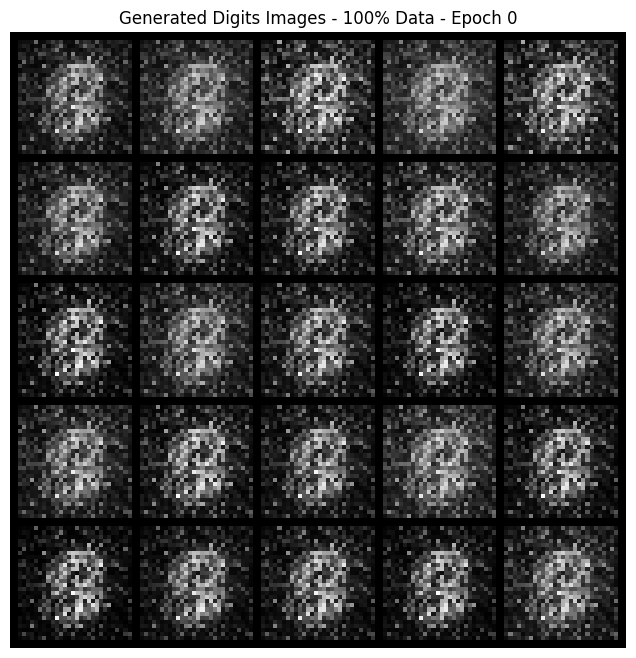

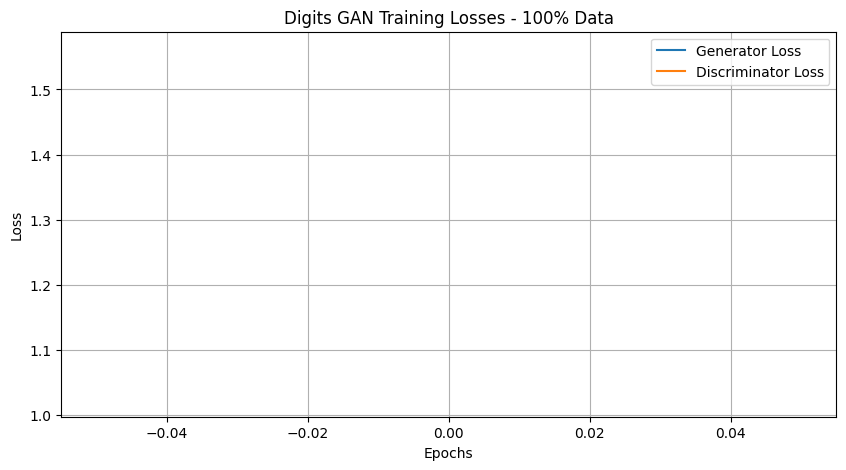

[Epoch 1/100] [Batch 0/468] [D loss: 0.8295] [G loss: 1.5814] [Time: 16.02s]
[Epoch 1/100] [Batch 100/468] [D loss: 0.9212] [G loss: 1.9372] [Time: 19.42s]
[Epoch 1/100] [Batch 200/468] [D loss: 0.8128] [G loss: 1.2210] [Time: 22.62s]
[Epoch 1/100] [Batch 300/468] [D loss: 0.8407] [G loss: 1.5232] [Time: 25.91s]
[Epoch 1/100] [Batch 400/468] [D loss: 0.8748] [G loss: 2.9254] [Time: 29.11s]
[Epoch 1/100] [Avg D loss: 0.8663] [Avg G loss: 2.1997]
[Epoch 2/100] [Batch 0/468] [D loss: 0.8994] [G loss: 1.8112] [Time: 31.33s]
[Epoch 2/100] [Batch 100/468] [D loss: 0.7746] [G loss: 1.7175] [Time: 34.84s]
[Epoch 2/100] [Batch 200/468] [D loss: 0.7797] [G loss: 2.1618] [Time: 38.35s]
[Epoch 2/100] [Batch 300/468] [D loss: 0.7293] [G loss: 1.4714] [Time: 41.38s]
[Epoch 2/100] [Batch 400/468] [D loss: 0.7602] [G loss: 2.5790] [Time: 44.49s]
[Epoch 2/100] [Avg D loss: 0.8095] [Avg G loss: 2.0869]
[Epoch 3/100] [Batch 0/468] [D loss: 0.7508] [G loss: 2.1477] [Time: 46.65s]
[Epoch 3/100] [Batch 100/

KeyboardInterrupt: 

In [12]:
set_random_seed(42)

# Parameters for the trainng run
dataset_type = 'digits'  # Change to 'fashion' for Fashion MNIST
subset_percentage = 100

# Train the GAN
g_losses, d_losses = train_gan(subset_percentage, dataset_type)

### Results Analysis

Let's examine our final loss plot and generate some images with the trained model.

In [ ]:
# Plot the losses
plot_losses(g_losses, d_losses, subset_percentage, dataset_type)

In [ ]:
# Generate random samples after training
generate_samples(dataset_type)

## 9. Next Steps for Thesis Research

1. **Data Subset Selection Strategies**:
   - Random sampling (as baseline)
   - Figure out a way to get informed subsest of the data
   - Compare subset selection effectiveness between Digits MNIST and Fashion MNIST

2. **Evaluation Metrics**:
   - Frechet Inception Distance (FID)
   - Inception Score (IS)
   - Precision and Recall metrics
   - Training stability measures

3. **Experiments to Run**:
   - Train with different subset sizes (10%, 20%, 30%, etc.)
   - Compare different subset selection methods
   - Analyze what makes certain samples more "informative" for GANs
   - Test if informative samples transfer across different GAN architectures
   - Compare the characteristics of informative samples between Digits MNIST and Fashion MNIST
   - Investigate whether informative samples from one dataset can generalize to another similar dataset